In [1]:
# For colab
from google.colab import drive
drive.mount('/content/Mydrive')
%cd "/content/Mydrive/MyDrive/Github/KT_Devchall"

Mounted at /content/Mydrive
/content/Mydrive/MyDrive/Github/KT_Devchall


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [3]:
import random
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import Dataset, DataLoader

# Preprocessing Pipeline


In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

set_config(display='diagram')

In [12]:
# data load
df_train = pd.read_pickle('data/train.pkl')
X = df_train.drop('Class', axis=1)
y = df_train['Class']

In [13]:
## Column Selection
feature_importance = pd.Series([3.12768611e+01, 6.62209523e+00, 1.55948023e+01, 1.05818328e+00,
       5.35072461e-02, 0.00000000e+00, 3.21271373e+00, 2.57594949e-02,
       1.17493059e+01, 9.91394069e-02, 9.48666051e+00, 9.53121732e-01,
       5.07253124e+00, 8.31159974e+00, 5.98996443e-02, 3.63612996e+00,
       2.78768950e+00], index = X.columns)
col_drop = feature_importance[feature_importance<0.1] 
col_drop

Platform      0.053507
OS_type       0.000000
Ex_Rate       0.025759
Country_ID    0.099139
weekend       0.059900
dtype: float64

In [14]:
X = X[X.columns.drop(col_drop.index)]

In [15]:
# num_features = ['Ex_Rate','P1','P2','P3','P4']
num_features = ['P1','P2','P3','P4']
cat_features = X.columns.drop(num_features).tolist()

In [16]:
# Transformer
numeric_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first', sparse=False)

In [17]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)

In [18]:
# Train/Val/Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, stratify=y)

In [19]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.4, stratify=y_val)

In [20]:
# Fit
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.fit_transform(X_val)
X_test = preprocessor.fit_transform(X_test) # 15s

# PyTorch Modeling

## Setting

In [21]:
# Seed setting

def def_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def_seed(seed=123)

In [23]:
# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
print(device)

cuda


## Dataset

In [24]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.df = X
        self.labels = y.values
    
    def __getitem__(self, index):
        self.x = self.df[index]
        self.y = self.labels[index]
        return torch.Tensor(self.x), self.y

    def __len__(self):
        return len(self.df)

## MLP Model

In [27]:
# Input dim
input_shape = X_train.shape[1]
input_shape

72

In [28]:
class Classifier(nn.Module):
    def __init__(self, input_shape):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_shape,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 30),
            nn.BatchNorm1d(30),
            nn.Dropout1d(0.1),
            nn.Linear(30, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer(x)
        return x

# Initialize Net
model = Classifier(input_shape = input_shape)
print(model)

Classifier(
  (layer): Sequential(
    (0): Linear(in_features=72, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=30, bias=True)
    (4): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout1d(p=0.1, inplace=False)
    (6): Linear(in_features=30, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


## Training Function

### EarlyStopper

In [29]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Trainer Code

In [30]:
# Model Trainer
def train_model(model, batch_size, patience, epochs, device):
    # Logging
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []

    # earlystopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    model.to(device)
    # Trainer
    for epoch in range(1, epochs + 1):
        model.train()
        for batch, (data, target) in enumerate(train_loader, 1):
            data = data.to(device)
            target = target.float().to(device)
            # clear gradients of all optimized variables
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view(-1,1))
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        
        # validation
        model.eval()
        for data, target in val_loader:
            data = data.to(device)
            target = target.float().to(device)
            output = model(data)
            loss = criterion(output, target.view(-1,1))
            valid_losses.append(loss.item())
        
        # loss per epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ')
        
        print(print_msg)

        # clear epoch list
        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early Stopping")
            break
        
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses

# Train

In [31]:
# Hyperparameters
epochs = 100
lr = 0.01
batch_size = 8192
patience = 5

# Criterion and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)

In [32]:
# To DataLoader
train = MyDataset(X_train, y_train)
val = MyDataset(X_val, y_val)
test = MyDataset(X_test, y_test)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, shuffle=False)

In [33]:
model, train_loss, valid_loss = train_model(model, batch_size, patience, epochs, device)

[  1/100] train_loss: 0.36497 valid_loss: 0.32842 
Validation loss decreased (inf --> 0.328422).  Saving model ...
[  2/100] train_loss: 0.35581 valid_loss: 0.32729 
Validation loss decreased (0.328422 --> 0.327295).  Saving model ...
[  3/100] train_loss: 0.35475 valid_loss: 0.32581 
Validation loss decreased (0.327295 --> 0.325808).  Saving model ...
[  4/100] train_loss: 0.35379 valid_loss: 0.32528 
Validation loss decreased (0.325808 --> 0.325279).  Saving model ...
[  5/100] train_loss: 0.35304 valid_loss: 0.32473 
Validation loss decreased (0.325279 --> 0.324731).  Saving model ...
[  6/100] train_loss: 0.35256 valid_loss: 0.32427 
Validation loss decreased (0.324731 --> 0.324267).  Saving model ...
[  7/100] train_loss: 0.35221 valid_loss: 0.32353 
Validation loss decreased (0.324267 --> 0.323533).  Saving model ...
[  8/100] train_loss: 0.35190 valid_loss: 0.32371 
EarlyStopping counter: 1 out of 7
[  9/100] train_loss: 0.35159 valid_loss: 0.32286 
Validation loss decreased (0.

## Train plot

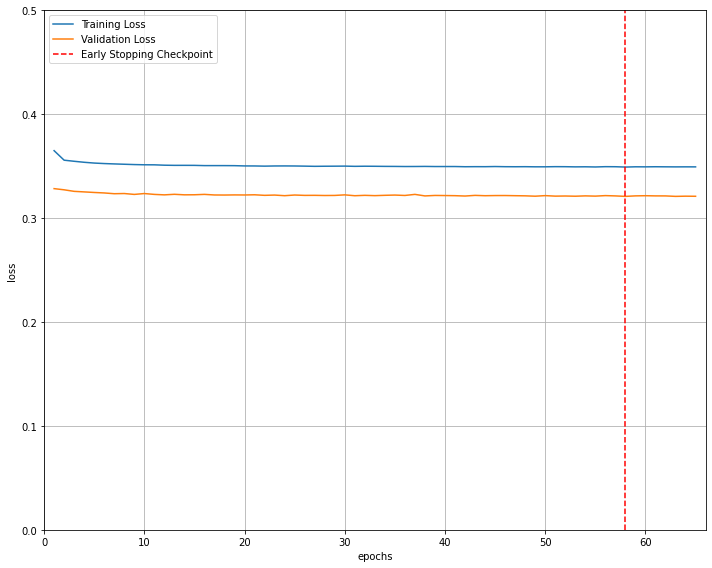

In [35]:
import matplotlib.pyplot as plt

# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot_torch.png')

# Test

In [ ]:
import itertools
from tqdm import tqdm

y_pred_list = []

# for prediction
model.eval()

with torch.no_grad():
    for data, target in tqdm(test_loader):
        data = data.to(device)
        y_test_pred = model(data)
        y_pred_tag = torch.round(y_test_pred).to('cpu')
        y_pred_list.append(y_pred_tag.detach().numpy())

y_pred_list = [i.squeeze().tolist() for i in y_pred_list]

In [41]:
# Prediction Score
y_true_test = y_test.values.ravel()

from sklearn.metrics import classification_report
print(classification_report(y_true_test, y_pred_list, target_names = ['Lose', 'Win']))

              precision    recall  f1-score   support

        Lose       0.85      0.95      0.90   1202206
         Win       0.83      0.60      0.70    502897

    accuracy                           0.85   1705103
   macro avg       0.84      0.78      0.80   1705103
weighted avg       0.84      0.85      0.84   1705103

